<a href="https://colab.research.google.com/github/Mario-U-KY/DataScience/blob/main/3_2_Linear_Regression_Implementation_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

<h2>3.2.1 Generating the Dataset

표준 정규 분포에서 부터 샘플링하는 2개의 feature, 1000개의 examples를 만들자.

true parameter 는 w = [2,-3.4] 그리고 b = 4.2로 세팅하자 

In [3]:
def synthetic_data(w,b,num_examples):
  """Generate y = Xw + b + noise."""
  X = torch.normal(0,1, (num_examples, len(w))) #1000 by len(w) 행렬로 mean 0 std 1 인 가우시안 분포에서 뽑아옴
  y = torch.matmul(X, w) + b #y값지정
  y += torch.normal(0,0.01,y.shape) #엡실론값지정
  return X, y.reshape((-1,1))#y column 1개가 되게 변환

true_w = torch.tensor([2,-3.4]) 
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
features[:5,:]

tensor([[ 0.0139, -3.0069],
        [ 1.0728,  2.6603],
        [ 0.3831,  1.4703],
        [ 1.6549,  0.8759],
        [ 0.1911, -0.2419]])

In [5]:
labels[:5]

tensor([[14.4490],
        [-2.7192],
        [-0.0364],
        [ 4.5358],
        [ 5.3931]])

X의 두번째 feature와 y변수를 매핑해보면 관련성을 확인해 볼 수 있다.

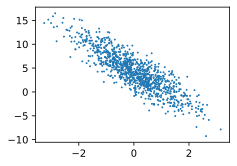

In [6]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

<h2> 3.2.2 Reading the Dataset

minibatch 뽑아내기

In [7]:
def data_iter(batch_size, features, labels):
  num_examples = len(features) #feature의 개수로 count
  indices = list(range(num_examples)) #0~example개수의 리스트 생성
  random.shuffle(indices) # 막 섞기
  for i in range(0, num_examples, batch_size): #0~ num_examples, batch_size 개수만큼 증가
    batch_indices = torch.tensor(
        indices[i: min(i+batch_size, num_examples)])#batch_size 단위만큼 뽑아내기
    yield features[batch_indices], labels[batch_indices]#현재 함수 중단, 바깥 코드 실행용 yield
  

In [8]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
  print(X, '\n', y)
  break #아래는 한번에 뽑아낸 양

tensor([[ 0.2374,  2.4572],
        [-0.9882,  0.2664],
        [ 0.2189,  0.2437],
        [ 1.7913,  1.0764],
        [-2.0899,  0.4228],
        [ 0.3340, -1.7138],
        [-0.0507, -0.2565],
        [-0.9793,  0.8430],
        [-0.4269,  0.2429],
        [ 0.9576, -0.6853]]) 
 tensor([[-3.6812],
        [ 1.3075],
        [ 3.8091],
        [ 4.1220],
        [-1.4187],
        [10.6777],
        [ 4.9625],
        [-0.6270],
        [ 2.5165],
        [ 8.4323]])


<h2>3.2.3. Initializing Model Parameters

In [9]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

<h2>3.2.4. Defining the Model


In [10]:
def linreg(X, w, b):  
    """The linear regression model."""
    return torch.matmul(X, w) + b

<h2>3.2.5. Defining the Loss Function

In [11]:
def squared_loss(y_hat, y):  
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

<h2>3.2.6. Defining the Optimization Algorithm

minibatch stochastic gradient descent.를 사용하자! 

In [12]:
def sgd(params, lr, batch_size):
  """Minibatch stochastic gradient descent."""
  with torch.no_grad():#gradient 트래킹 하지 않음
    for param in params:
      param -= lr * param.grad/batch_size
      param.grad.zero_()

<h2>3.2.7 Training

각 iteration 마다 minibatch 를 뽑아냄 -> 모델에 보내서 예측을 실행 -> loss값 계산 -> initiate backwards pass thought the network 각 파라미터 별 gradient를 storing 하면서. 최종적으로 sgd를 지나가면서 parameter를 업데이트 한다.

Initialize parameters 

Repeat until done

Compute gradient 

Update parameters 

각 epoch마다 전체 데이터 셋을 다 돈다. num_epochs와 learning rate lr 는 하이퍼파라미터가 된다. 

In [14]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)#예측값과 실제값 y 이용해서 loss 구함.
    l.sum().backward() #현재까지 누적된 파라미터의 연산을 반환
    sgd([w,b],lr,batch_size) # 
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch+1}, loss{float(train_l.mean()):f}')

epoch 1, loss0.031700
epoch 2, loss0.000116
epoch 3, loss0.000053


실제값이랑 비교해서 error 찾아보자

In [16]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0006, -0.0003], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0006], grad_fn=<RsubBackward1>)


궁금해서 해보는 epoch, running rate 변경

In [19]:
lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)#예측값과 실제값 y 이용해서 loss 구함.
    l.sum().backward() #현재까지 누적된 파라미터의 연산을 반환
    sgd([w,b],lr,batch_size) # 
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch+1}, loss{float(train_l.mean()):f}')

epoch 1, loss0.000053
epoch 2, loss0.000053
epoch 3, loss0.000053
epoch 4, loss0.000053
epoch 5, loss0.000053
epoch 6, loss0.000053
epoch 7, loss0.000053
epoch 8, loss0.000053
epoch 9, loss0.000053
epoch 10, loss0.000053


In [20]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0004, -0.0001], grad_fn=<SubBackward0>)
error in estimating b: tensor([-8.2970e-05], grad_fn=<RsubBackward1>)
